In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm
import os

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA version: 12.8
Number of GPUs: 1
Current GPU: NVIDIA RTX 6000 Ada Generation


## (a) Load CIFAR-10 Dataset

In [3]:
grayscale = False

transform_list = []
if grayscale:
    transform_list.append(transforms.Grayscale())
transform_list.extend([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])
transform = transforms.Compose(transform_list)

# Add code to import the CIFAR10 dataset
dataset_root = '../datasets'
train_dataset_ = torchvision.datasets.CIFAR10(root=dataset_root, train = True, download = True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(root=dataset_root, train = False, download = True, transform = transform)

100%|██████████| 170M/170M [00:16<00:00, 10.4MB/s] 


In [4]:
### Dataset exploration, no changes required here
targets = np.array(train_dataset_.targets)
print(f'  {"Name":10s} Count')
for ix in range(targets.max()):
  print(f'{ix} {train_dataset_.classes[ix]:10s} {sum(targets == ix)}')
print()
# The data is stored in a tensor with the following dimensions
print(f'Dimensions of training dataset tensor:\n\t{train_dataset_.data.shape}\n')
print(f'Dimensions of testing dataset tensor:\n\t{test_dataset.data.shape}')
print()
print(f'Dataset target labels:\n\t{train_dataset_.classes}\n')
print(f'Dataset target dimensions:\n\t{len(train_dataset_.targets)}')
print()
print(f'Max value: {train_dataset_.data.max()}')
print(f'Min value: {train_dataset_.data.min()}')

  Name       Count
0 airplane   5000
1 automobile 5000
2 bird       5000
3 cat        5000
4 deer       5000
5 dog        5000
6 frog       5000
7 horse      5000
8 ship       5000

Dimensions of training dataset tensor:
	(50000, 32, 32, 3)

Dimensions of testing dataset tensor:
	(10000, 32, 32, 3)

Dataset target labels:
	['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Dataset target dimensions:
	50000

Max value: 255
Min value: 0


# Visualize the Dataset

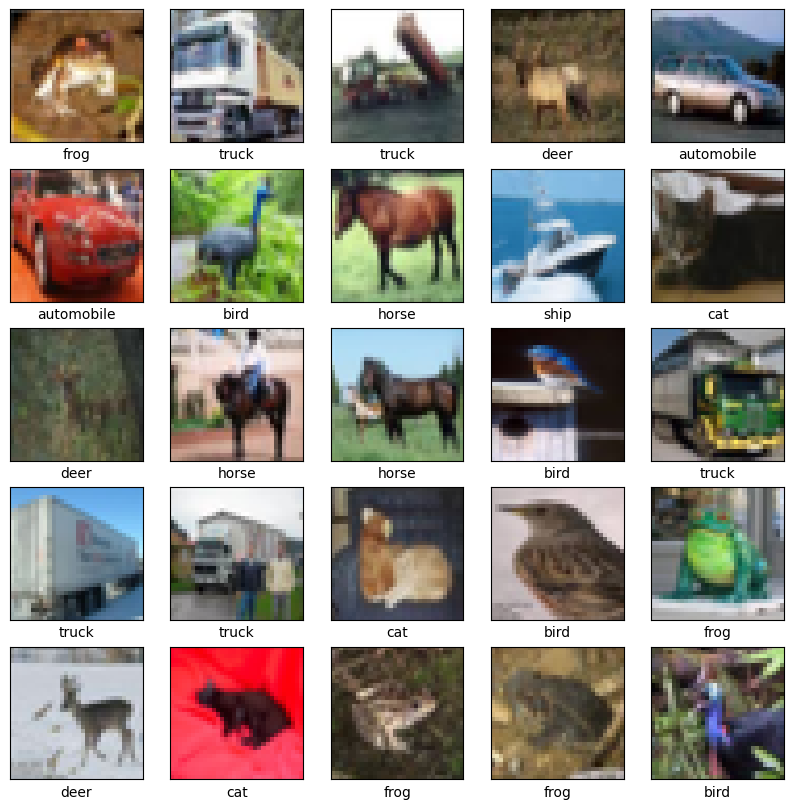

In [5]:
### No changes required here
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))

# Show first 25 training images below
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_dataset_[i][0].permute(1,2,0), cmap=plt.cm.gray)
    plt.xlabel(train_dataset_.classes[train_dataset_[i][1]])

## (b) Create Validation Dataset

In [6]:
### Use random_split to make a validation dataset from the training dataset.
train_size = int(0.8 * len(train_dataset_))
val_size = len(train_dataset_) - train_size

train_dataset, val_dataset = random_split(train_dataset_, [train_size, val_size])

## (c) Setup DataLoaders

In [7]:
### Make a validation dataset loader and set batch size
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# (d) Network Architecture

In [8]:
class CIFAR10Model(torch.nn.Module):
  # You may add/delete parameters to the constructor to suit
  # your model
  def __init__(self, input_layer_size, hidden_layer_size, output_layer_size):
    super(CIFAR10Model, self).__init__()
    print(f'Model: input_size {input_layer_size} hidden_size {hidden_layer_size} num_classes {output_layer_size}')

    self.network = nn.Sequential(
      ### Insert your network description here
      nn.Flatten(),

      nn.Linear(input_layer_size, hidden_layer_size),
      nn.BatchNorm1d(hidden_layer_size),
      nn.GELU(),
      nn.Dropout(0.3),

      nn.Linear(hidden_layer_size, hidden_layer_size // 2),
      nn.BatchNorm1d(hidden_layer_size//2),
      nn.GELU(),
      nn.Dropout(0.3),

      nn.Linear(hidden_layer_size // 2, hidden_layer_size // 4),
      nn.BatchNorm1d(hidden_layer_size//4),
      nn.GELU(),
      nn.Dropout(0.3),

      nn.Linear(hidden_layer_size // 4, output_layer_size)

      )

  def forward(self, x):
    return self.network(x)

## (e) Set Hyperparameters

In [9]:
### Set your hyperparameters
# You may added additional hyperparameters here
training_epochs = 100
learning_rate = 3e-4

output_layer_size = 10
input_layer_size = 3072 if not grayscale else 1024
hidden_layer_size = 1024

The code is used to compile predictions and losses for one epoch.

In [10]:
### No changes required here
def check_performance(model, loss, loader, device):
  """
  Return dictionary of performance statistics.
  Arguments:
    model - Instance of network architecture
    loss - Loss function
    loader - DataLoader object from which to compile statistics
    device - either CPU or CUDA device

  Returns:
    dictionary with the following keys:
    'losses': Loss for each minibatch
    'predictions': Predicted class for each item in minibatch
    'targets': True label for each item in minibatch
  """
  losses = []
  all_preds = []
  all_targets = []

  #The eval mode and torch.no_grad are called to avoid computing things not
  # required for a forward pass, like gradient computations
  model.eval()
  with torch.no_grad():
    for features, target in loader:
      predictions = model(features.to(device))
      # Compute the loss with the testing data.  This should track the training
      # loss, at least at the start of training.
      error = loss(predictions, target.to(device))
      losses.append(error.item())

      preds = predictions.argmax(axis=1)
      all_preds.append(preds)
      all_targets.append(target)

  return {'losses': losses,
          'predictions': torch.hstack(all_preds).cpu(),
          'targets': torch.hstack(all_targets).cpu()
          }

## Training loop

In [11]:
### No changes required here, but you may wish to change the optimizer or loss.

#Make instance of the network
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:',device)

model = CIFAR10Model(input_layer_size, hidden_layer_size, output_layer_size).to(device)
# Loss function
loss = torch.nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
# Optimizer - Can experiment with ADAM, SGD, etc.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

# performance statistics for each epoch
stats_per_epoch = {
  'train_loss': [],
  'train_accuracy': [],
  'val_loss': [],
  'val_accuracy': []
  }

best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
epochs_no_improve = 0
early_stop = False

model.train()  # Put model in train mode so it tracks gradients, etc. for optimization
for i in range(training_epochs):
  if early_stop:
        print("Early stopping triggered!")
        break
      
  print(f'Epoch: {i}')
  train_losses = []
  train_correct = 0
  train_total = 0

  for features, target in tqdm(train_loader):
    optimizer.zero_grad()                       # do not accumulate gradients

    features = features.to(device)
    target = target.to(device)

    predictions = model(features)               # forward pass
    error = loss(predictions, target)           # compute loss
    train_losses.append(error.item())

    _, predicted = torch.max(predictions.data, 1)
    train_total += target.size(0)
    train_correct += (predicted == target).sum().item()

    error.backward()                            # backward pass
    optimizer.step()                            # update weights

  # Per epoch stats
  stats_per_epoch['train_loss'].append(np.mean(train_losses))
  stats_per_epoch['train_accuracy'].append(train_correct / train_total)
  perf = check_performance(model, loss, val_loader, device)
  current_val_loss = np.mean(perf['losses'])  
  current_val_acc = (sum(perf['targets'] == perf['predictions']) / len(perf['targets'])).item()

  stats_per_epoch['val_loss'].append(current_val_loss)
  stats_per_epoch['val_accuracy'].append(current_val_acc)

  print(f'\tMean train loss: {stats_per_epoch["train_loss"][-1]:.3f}')
  print(f'\tMean validation loss: {current_val_loss:.3f}')
  print(f'\tMean train accuracy: {stats_per_epoch["train_accuracy"][-1]:.3f}')
  print(f'\tMean validation accuracy: {current_val_acc:.3f}')
  
  # EARLY STOPPING
  if current_val_loss < best_val_loss:
      best_val_loss = current_val_loss
      epochs_no_improve = 0
  else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
          early_stop = True
  

# End of run stats
test_perf = check_performance(model, loss, test_loader, device)
stats_per_epoch['test_loss'] = np.mean(test_perf['losses'])
stats_per_epoch['test_accuracy'] = (sum(test_perf['targets'] == test_perf['predictions']) / len(test_perf['targets'])).item()

print(f'Mean test loss: {stats_per_epoch["test_loss"]:.3f}')
print(f'Mean test accuracy: {stats_per_epoch["test_accuracy"]:.3f}')


Device is: cuda
Model: input_size 3072 hidden_size 1024 num_classes 10
Epoch: 0


100%|██████████| 313/313 [00:02<00:00, 129.63it/s]


	Mean train loss: 1.839
	Mean validation loss: 1.725
	Mean train accuracy: 0.388
	Mean validation accuracy: 0.434
Epoch: 1


100%|██████████| 313/313 [00:02<00:00, 144.32it/s]


	Mean train loss: 1.727
	Mean validation loss: 1.740
	Mean train accuracy: 0.437
	Mean validation accuracy: 0.429
Epoch: 2


100%|██████████| 313/313 [00:02<00:00, 144.40it/s]


	Mean train loss: 1.651
	Mean validation loss: 1.666
	Mean train accuracy: 0.470
	Mean validation accuracy: 0.473
Epoch: 3


100%|██████████| 313/313 [00:02<00:00, 145.38it/s]


	Mean train loss: 1.588
	Mean validation loss: 1.627
	Mean train accuracy: 0.499
	Mean validation accuracy: 0.487
Epoch: 4


100%|██████████| 313/313 [00:02<00:00, 144.88it/s]


	Mean train loss: 1.559
	Mean validation loss: 1.642
	Mean train accuracy: 0.512
	Mean validation accuracy: 0.479
Epoch: 5


100%|██████████| 313/313 [00:02<00:00, 145.34it/s]


	Mean train loss: 1.520
	Mean validation loss: 1.624
	Mean train accuracy: 0.533
	Mean validation accuracy: 0.484
Epoch: 6


100%|██████████| 313/313 [00:02<00:00, 139.14it/s]


	Mean train loss: 1.485
	Mean validation loss: 1.591
	Mean train accuracy: 0.548
	Mean validation accuracy: 0.508
Epoch: 7


100%|██████████| 313/313 [00:02<00:00, 145.70it/s]


	Mean train loss: 1.449
	Mean validation loss: 1.568
	Mean train accuracy: 0.567
	Mean validation accuracy: 0.510
Epoch: 8


100%|██████████| 313/313 [00:02<00:00, 143.61it/s]


	Mean train loss: 1.418
	Mean validation loss: 1.561
	Mean train accuracy: 0.581
	Mean validation accuracy: 0.516
Epoch: 9


100%|██████████| 313/313 [00:02<00:00, 151.51it/s]


	Mean train loss: 1.384
	Mean validation loss: 1.565
	Mean train accuracy: 0.596
	Mean validation accuracy: 0.522
Epoch: 10


100%|██████████| 313/313 [00:02<00:00, 153.64it/s]


	Mean train loss: 1.356
	Mean validation loss: 1.570
	Mean train accuracy: 0.615
	Mean validation accuracy: 0.522
Epoch: 11


100%|██████████| 313/313 [00:02<00:00, 155.67it/s]


	Mean train loss: 1.315
	Mean validation loss: 1.577
	Mean train accuracy: 0.634
	Mean validation accuracy: 0.510
Early stopping triggered!
Mean test loss: 1.569
Mean test accuracy: 0.512


## (f) Plot Your Results

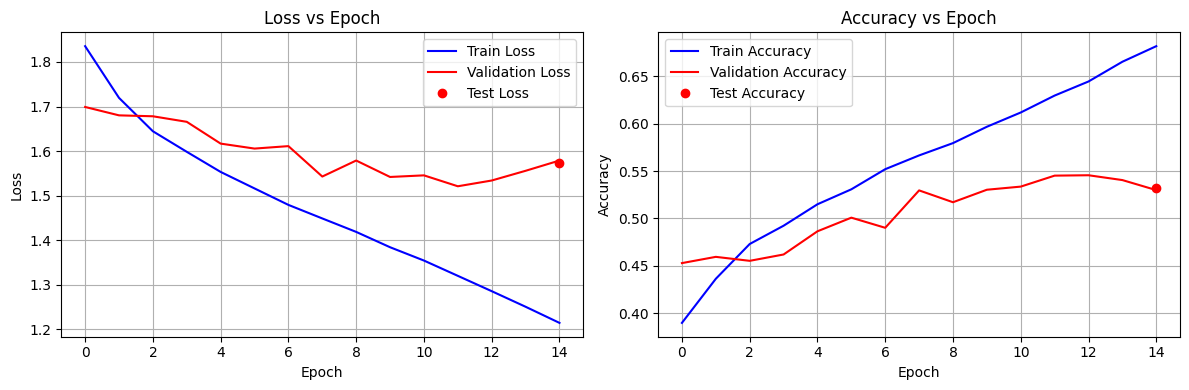

In [16]:
epochs = range(len(stats_per_epoch['train_loss']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot Loss
ax1.plot(epochs, stats_per_epoch['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, stats_per_epoch['val_loss'], 'r-', label='Validation Loss')

last_epoch = len(epochs) - 1
ax1.plot(last_epoch, stats_per_epoch['test_loss'], 'ro', label='Test Loss')  

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Epoch')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, stats_per_epoch['train_accuracy'], 'b-', label='Train Accuracy')
ax2.plot(epochs, stats_per_epoch['val_accuracy'], 'r-', label='Validation Accuracy')

ax2.plot(last_epoch, stats_per_epoch['test_accuracy'], 'ro', label='Test Accuracy')  

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch')
ax2.legend()
ax2.grid(True)

plt.savefig(f'plots/ann_{learning_rate}_{batch_size}_{training_epochs}_{hidden_layer_size}_{grayscale}.png')
plt.tight_layout()
plt.show()


# Visualize the Predictions

In [17]:
# Code to visualize predictions
# Incorrect predictions are highlighted in red
def visualize(dataset, stats, errors = None):
  if errors is None:
    errors = []
    print('Correct Label in ()')
  else:
    print(f'Errors where true label is {dataset.classes[stats["targets"][errors[0]]]}')

  plt.figure(figsize=(10,10))
  for i in range(min(len(errors), 25) if len(errors) else 25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      j = errors[i] if len(errors) else i
      plt.imshow(dataset[j][0].permute(1,2,0), cmap=plt.cm.gray)
      predicted_label = stats['predictions'][j]
      true_label = stats['targets'][j]
      if predicted_label == true_label:
        color = 'green'
      else:
        color = 'red'
      plt.xlabel("{} ({})".format(dataset.classes[predicted_label],
                                  dataset.classes[true_label]),
                                  color=color)

Correct Label in ()


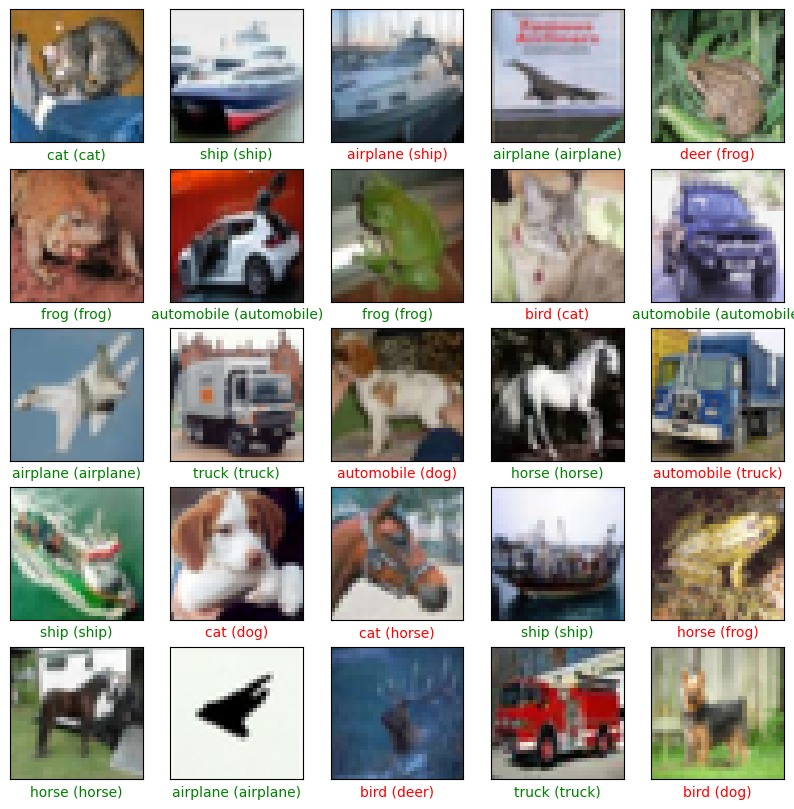

In [18]:
### Show first 25 predictions
visualize(test_dataset, test_perf)

Errors where true label is cat


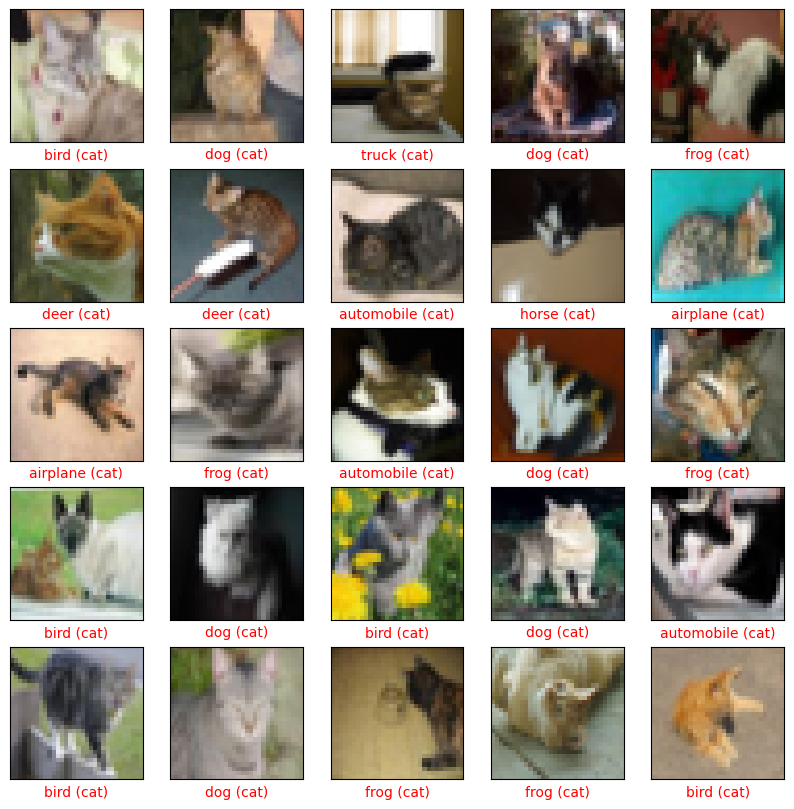

In [19]:
### Show first 25 predictions that are incorrect for a specific class

# get a list of indices where there is an error
true_class_ix = 3 # expected class is 3 (cat)
errors = np.where(test_perf['targets'] != test_perf['predictions'])[0]
e2 = np.where(test_perf['targets']==true_class_ix)[0]
errors = np.intersect1d(e2,errors)

visualize(test_dataset, test_perf, errors)